# SQL Layout Analysis Playground (TPC-H)

这个 notebook 用于做两件事：
1. 统计多条 SQL 中各表/各列在 `WHERE` / `JOIN ON` 中的使用情况（含谓词类型、layout heuristic score）
2. 结合 `workloads/stats/*.yaml` 的列分布信息（`cardinality/kind/topk/hist`）做分析与画图

说明：当前环境没有 `sqlglot`，工具会使用一个面向 TPC-H 的启发式解析器（够你先 play 和 debug）。以后装上 `sqlglot` 可以继续增强精度。

In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

ROOT = Path.cwd()
if not (ROOT / 'notebooks').exists() and (ROOT.parent / 'notebooks').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from notebooks import sql_layout_toolkit as slt

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
ROOT

PosixPath('/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc')

In [2]:
# ---- Config (edit me) ----
# Option A: use the RQ6 TPCH-all workload stream(s)
SQL_FILES = slt.example_tpch_file_selection(stream='stream_1', root=ROOT / 'workloads/rq6_tpch_all')

# Option B: custom glob examples
# SQL_FILES = slt.discover_sql_files(include_globs=['workloads/rq6_tpch_all/stream_*/query_*.sql'])
# SQL_FILES = slt.discover_sql_files(include_globs=['workloads/tpch_16_Q*/**/*.sql'])

STATS_YAML = ROOT / 'workloads/stats/tpch_16_stats.yaml'
TOP_K = 12
TABLES_TO_PLOT = ['lineitem', 'orders']

len(SQL_FILES), SQL_FILES[:3]

(20,
 [PosixPath('/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/workloads/rq6_tpch_all/stream_1/query_01.sql'),
  PosixPath('/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/workloads/rq6_tpch_all/stream_1/query_02.sql'),
  PosixPath('/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/workloads/rq6_tpch_all/stream_1/query_03.sql')])

In [3]:
result = slt.analyze_sql_and_stats(SQL_FILES, STATS_YAML)
analysis = result['analysis']
predicates = result['predicates']
summary = result['summary']
summary_enriched = result['summary_enriched']
cooccurrence = result['cooccurrence']
join_summary = result['join_summary']
stats_df = result['stats']

analysis.meta

{'parser': 'heuristic',
 'sqlglot_available': True,
 'sqlglot_used': False,
 'pred_weight': {'eq': 5.0,
  'in': 4.0,
  'range': 3.0,
  'like': 2.0,
  'null': 1.0,
  'other': 1.0},
 'table_role_weight': {'lineitem': 1.2}}

In [4]:
print('Predicate events:', len(predicates))
print('Columns in summary:', len(summary))
print('Tables found:', sorted(summary['table'].dropna().unique().tolist()))

display(slt.summarize_tables_for_display(summary_enriched, top_k=TOP_K))

Predicate events: 190
Columns in summary: 38
Tables found: ['customer', 'lineitem', 'nation', 'orders', 'part', 'partsupp', 'region', 'supplier']


,table,column,table_column,occurrences,queries,score,filters,joins,or_occurrences,eq,in,like,range,pred_eq_ratio,pred_in_ratio,pred_range_ratio,pred_like_ratio,null,pred_null_ratio,other,pred_other_ratio,kind,count,cardinality,null_ratio,unique_ratio,distinctness_bucket,is_low_cardinality,is_unique_like
0,customer,c_custkey,customer.c_custkey,8,8,40.0,0,8,0,8,0,0,0,1.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer,c_nationkey,customer.c_nationkey,4,4,20.0,0,4,0,4,0,0,0,1.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer,c_phone,customer.c_phone,2,1,8.0,2,0,0,0,2,0,0,0.000000,1.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,customer,c_mktsegment,customer.c_mktsegment,1,1,5.0,1,0,0,1,0,0,0,1.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer,c_acctbal,customer.c_acctbal,1,1,4.0,1,0,0,0,1,0,0,0.000000,1.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,lineitem,l_orderkey,lineitem.l_orderkey,13,10,69.6,1,12,0,9,1,0,3,0.692308,0.076923,0.230769,0.000000,0,0.0,0,0.0,numeric,200000.0,19989.0,0.0,0.099945,medium,False,False
6,lineitem,l_suppkey,lineitem.l_suppkey,9,6,45.6,1,8,0,6,0,1,2,0.666667,0.000000,0.222222,0.111111,0,0.0,0,0.0,numeric,200000.0,18788.0,0.0,0.093940,medium,False,False
7,lineitem,l_partkey,lineitem.l_partkey,10,6,41.4,4,6,3,5,0,1,4,0.500000,0.000000,0.400000,0.100000,0,0.0,0,0.0,numeric,200000.0,19939.0,0.0,0.099695,medium,False,False
8,lineitem,l_shipdate,lineitem.l_shipdate,9,7,31.2,8,1,0,0,0,1,8,0.000000,0.000000,0.888889,0.111111,0,0.0,0,0.0,datetime,200000.0,2495.0,0.0,0.012475,medium,False,False
9,lineitem,l_receiptdate,lineitem.l_receiptdate,6,3,21.6,2,4,0,0,0,0,6,0.000000,0.000000,1.000000,0.000000,0,0.0,0,0.0,datetime,200000.0,2501.0,0.0,0.012505,medium,False,False


In [5]:
# 你最关心的结果 1：每个表哪些列被用到了 + 分布情况如何
cols = [
    'table', 'column', 'score', 'occurrences', 'queries', 'filters', 'joins',
    'eq', 'in', 'range', 'like', 'null',
    'kind', 'cardinality', 'count', 'unique_ratio', 'distinctness_bucket', 'is_low_cardinality', 'is_unique_like'
]
display(summary_enriched[cols].sort_values(['table', 'score'], ascending=[True, False]))

,table,column,score,occurrences,queries,filters,joins,eq,in,range,like,null,kind,cardinality,count,unique_ratio,distinctness_bucket,is_low_cardinality,is_unique_like
0,customer,c_custkey,40.0,8,8,0,8,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer,c_nationkey,20.0,4,4,0,4,4,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer,c_phone,8.0,2,1,2,0,0,2,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,customer,c_mktsegment,5.0,1,1,1,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer,c_acctbal,4.0,1,1,1,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,lineitem,l_orderkey,69.6,13,10,1,12,9,1,3,0,0,numeric,19989.0,200000.0,0.099945,medium,False,False
6,lineitem,l_suppkey,45.6,9,6,1,8,6,0,2,1,0,numeric,18788.0,200000.0,0.093940,medium,False,False
7,lineitem,l_partkey,41.4,10,6,4,6,5,0,4,1,0,numeric,19939.0,200000.0,0.099695,medium,False,False
8,lineitem,l_shipdate,31.2,9,7,8,1,0,0,8,1,0,datetime,2495.0,200000.0,0.012475,medium,False,False
9,lineitem,l_receiptdate,21.6,6,3,2,4,0,0,6,0,0,datetime,2501.0,200000.0,0.012505,medium,False,False


In [6]:
# 按表看 join key 统计（单独看，方便决定是否要把 join key 纳入 layout）
display(join_summary.sort_values(['join_occurrences', 'join_queries'], ascending=False).head(50))

,table,column,table_column,join_occurrences,join_queries
3,lineitem,l_orderkey,lineitem.l_orderkey,12,10
10,nation,n_nationkey,nation.n_nationkey,11,8
13,orders,o_orderkey,orders.o_orderkey,10,10
18,supplier,s_nationkey,supplier.s_nationkey,9,7
0,customer,c_custkey,customer.c_custkey,8,8
12,orders,o_custkey,orders.o_custkey,8,8
8,lineitem,l_suppkey,lineitem.l_suppkey,8,5
19,supplier,s_suppkey,supplier.s_suppkey,7,6
14,part,p_partkey,part.p_partkey,6,5
4,lineitem,l_partkey,lineitem.l_partkey,6,4


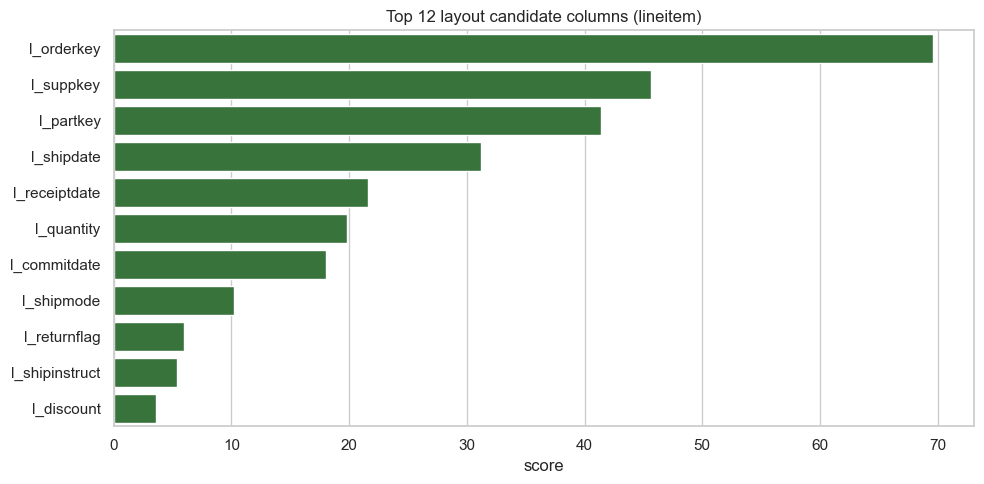

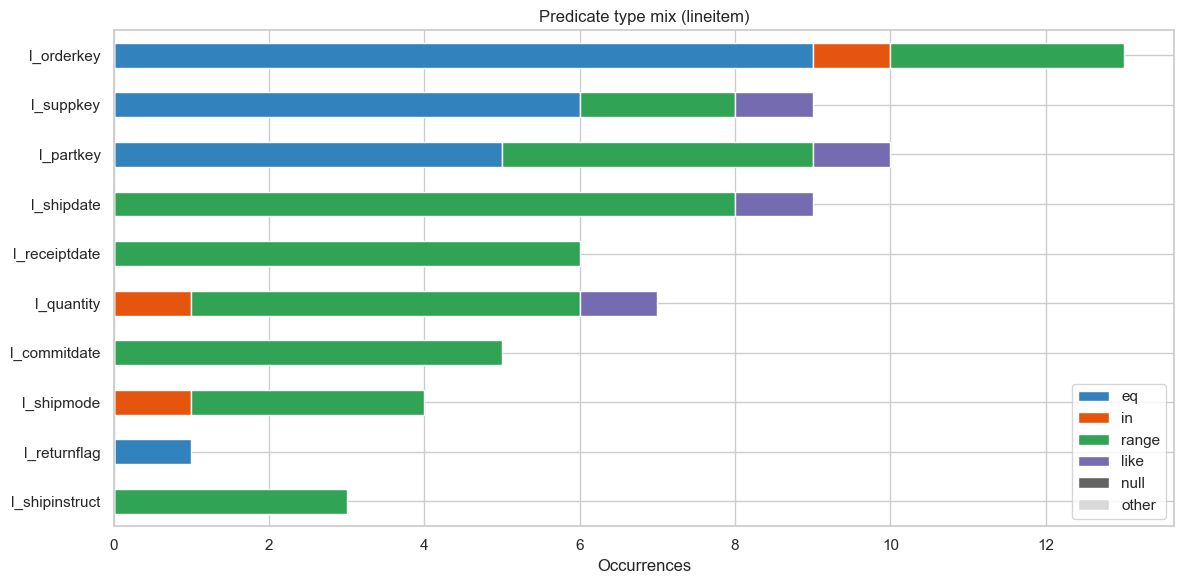

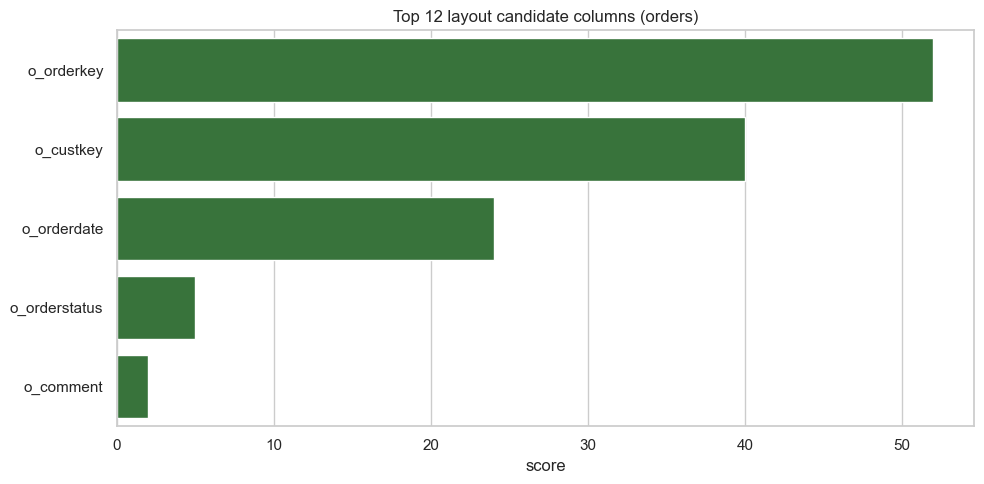

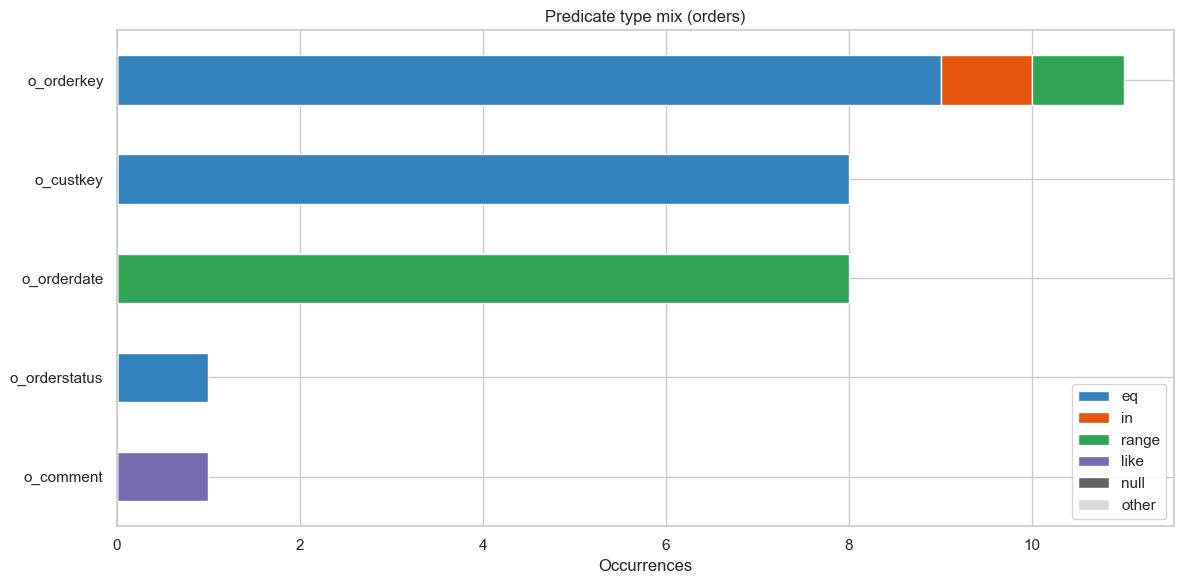

In [7]:
# 你最关心的结果 2：画图（按表）
for tbl in TABLES_TO_PLOT:
    if tbl not in set(summary_enriched['table']):
        print(f'skip {tbl}: not found')
        continue
    slt.plot_top_columns(summary_enriched, table=tbl, top_k=TOP_K)
    plt.show()
    slt.plot_predicate_mix(summary_enriched, table=tbl, top_k=min(TOP_K, 10))
    plt.show()


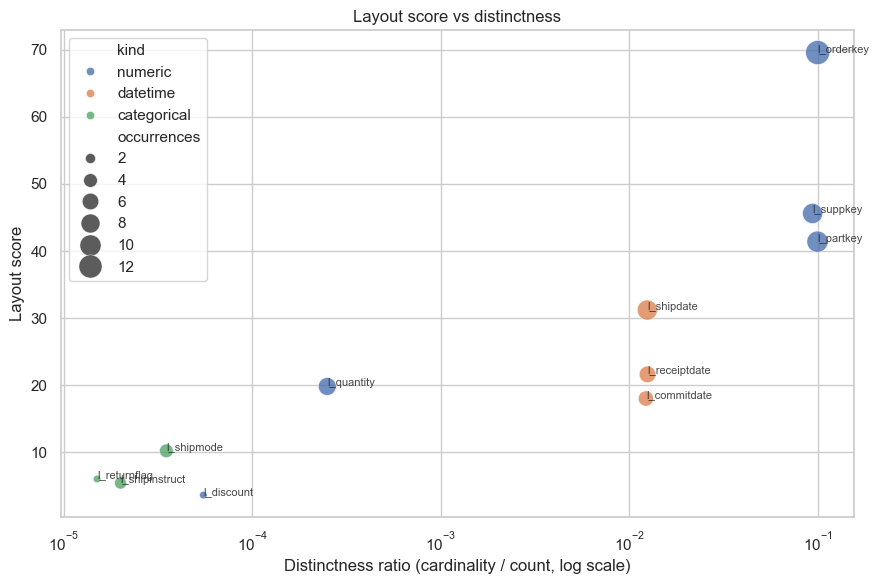

In [8]:
# score vs distinctness (cardinality/count)
# 对于很低基数列（类别列）和近唯一列（key），这张图很直观
slt.plot_score_vs_distinctness(summary_enriched, table=None)
plt.show()

,table,col_a,col_b,pair,count
4,lineitem,l_partkey,l_quantity,l_partkey|l_quantity,2
9,lineitem,l_quantity,l_shipdate,l_quantity|l_shipdate,2
1,lineitem,l_discount,l_quantity,l_discount|l_quantity,1
2,lineitem,l_discount,l_shipdate,l_discount|l_shipdate,1
3,lineitem,l_orderkey,l_quantity,l_orderkey|l_quantity,1
5,lineitem,l_partkey,l_shipdate,l_partkey|l_shipdate,1
6,lineitem,l_partkey,l_shipinstruct,l_partkey|l_shipinstruct,1
7,lineitem,l_partkey,l_shipmode,l_partkey|l_shipmode,1
8,lineitem,l_partkey,l_suppkey,l_partkey|l_suppkey,1
10,lineitem,l_quantity,l_shipinstruct,l_quantity|l_shipinstruct,1


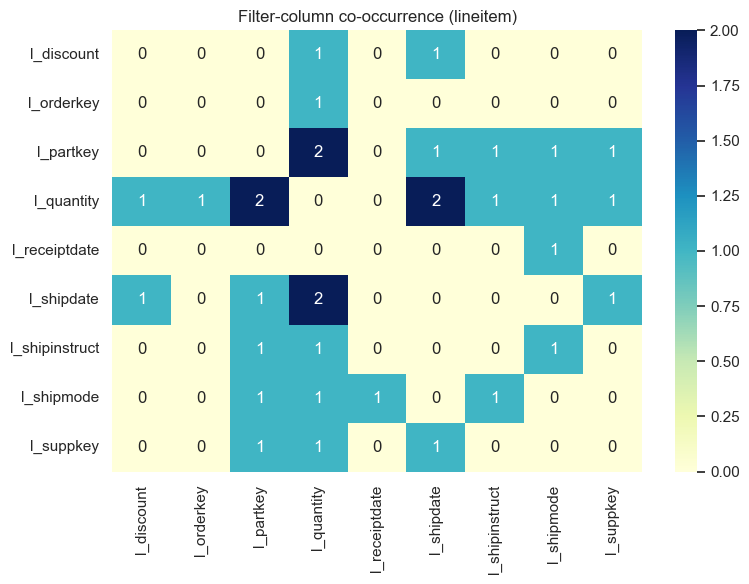

No cooccurrence for orders


In [9]:
# 多维 layout 候选：看列共现（只统计 filter 列共现）
for tbl in TABLES_TO_PLOT:
    g = cooccurrence[cooccurrence['table'] == tbl] if not cooccurrence.empty else cooccurrence
    if g.empty:
        print(f'No cooccurrence for {tbl}')
        continue
    display(g.sort_values('count', ascending=False).head(20))
    try:
        slt.plot_cooccurrence_heatmap(cooccurrence, table=tbl, min_count=1)
        plt.show()
    except Exception as e:
        print(f'heatmap skipped for {tbl}: {e}')


In [10]:
# 可选：自定义权重（例如更强调 range，或者取消 lineitem boost）
custom_pred_weight = dict(slt.PRED_WEIGHT_DEFAULT)
custom_pred_weight['range'] = 4.0
custom_table_weight = {}  # e.g. {'lineitem': 1.0}

result_custom = slt.analyze_sql_and_stats(SQL_FILES, STATS_YAML, pred_weight=custom_pred_weight, table_role_weight=custom_table_weight)
display(slt.summarize_tables_for_display(result_custom['summary_enriched'], top_k=8))

,table,column,table_column,occurrences,queries,score,filters,joins,or_occurrences,eq,in,like,range,pred_eq_ratio,pred_in_ratio,pred_range_ratio,pred_like_ratio,null,pred_null_ratio,other,pred_other_ratio,kind,count,cardinality,null_ratio,unique_ratio,distinctness_bucket,is_low_cardinality,is_unique_like
0,customer,c_custkey,customer.c_custkey,8,8,40.0,0,8,0,8,0,0,0,1.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer,c_nationkey,customer.c_nationkey,4,4,20.0,0,4,0,4,0,0,0,1.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer,c_phone,customer.c_phone,2,1,8.0,2,0,0,0,2,0,0,0.000000,1.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,customer,c_mktsegment,customer.c_mktsegment,1,1,5.0,1,0,0,1,0,0,0,1.000000,0.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer,c_acctbal,customer.c_acctbal,1,1,4.0,1,0,0,0,1,0,0,0.000000,1.000000,0.000000,0.000000,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,lineitem,l_orderkey,lineitem.l_orderkey,13,10,61.0,1,12,0,9,1,0,3,0.692308,0.076923,0.230769,0.000000,0,0.0,0,0.0,numeric,200000.0,19989.0,0.0,0.099945,medium,False,False
6,lineitem,l_suppkey,lineitem.l_suppkey,9,6,40.0,1,8,0,6,0,1,2,0.666667,0.000000,0.222222,0.111111,0,0.0,0,0.0,numeric,200000.0,18788.0,0.0,0.093940,medium,False,False
7,lineitem,l_partkey,lineitem.l_partkey,10,6,37.0,4,6,3,5,0,1,4,0.500000,0.000000,0.400000,0.100000,0,0.0,0,0.0,numeric,200000.0,19939.0,0.0,0.099695,medium,False,False
8,lineitem,l_shipdate,lineitem.l_shipdate,9,7,34.0,8,1,0,0,0,1,8,0.000000,0.000000,0.888889,0.111111,0,0.0,0,0.0,datetime,200000.0,2495.0,0.0,0.012475,medium,False,False
9,lineitem,l_receiptdate,lineitem.l_receiptdate,6,3,24.0,2,4,0,0,0,0,6,0.000000,0.000000,1.000000,0.000000,0,0.0,0,0.0,datetime,200000.0,2501.0,0.0,0.012505,medium,False,False
